<!--COURSE_INFORMATION-->
*This notebook contains course material from [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/CBE30338).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Coding Controllers with Python Generators](B.11-Coding-Controllers-with-Python-Generators.ipynb) | [Contents](index.ipynb) |

<a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/B.12-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Laboratory Session 4. Open and Closed Loop Estimation

This notebook outlines three experiments to be performed using the TCLab hardware. This first cell imports necessary libraries, defines a relay control as a Python generator, and a temperature setpoint.

Text(0.5, 1.0, 'Temperature Setpoint')

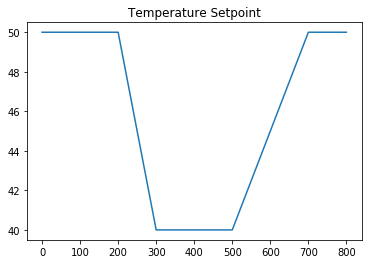

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# Relay Control
def relay(Qmin, Qmax):
    Q = 0
    while True:
        Tsp, T = yield Q
        Q = Qmax if T < Tsp else Qmin
        

# Temperature Setpoint
def Tsp(t):
    tp = [  0,  200,  300,  500,  700, 9999]
    Tp = [ 50,   50,   40,   40,   50,   50]
    return np.interp(t, tp, Tp)

t = np.linspace(0, 800, 801)
plt.plot(t, Tsp(t))
plt.title('Temperature Setpoint')

## Experiment 1. Open-Loop State Estimation and Relay Control

In this first experiment, use a closed loop estimator and relay control to cause the heater to track a desired temperature setpoint. Perform the following tasks:

**a.**) This code was cut and paste from Thursday's lecture. Adjust the setup to interface with the lab device rather than simuation.

**b.**) When you run the experiment, for the first 400 seconds keep the Arduino/TCLab device carefully shielded from any air currents. For example, you might use the plastic lab kit as a shield.  Once you have established operation for about 400 seconds, move the Arduino/TCLab to an open area where it will be subject to air currents.  If needed, use a sheet of paper to fan some air over the device.  

**c.**) Describe what you see. Does the controller track the setpoint?  Does the controller reject disturbances?  Explain why this system displays the behavior you're seeing.

#### Open Loop Estimation

In [2]:
import numpy as np
import control 

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q])
        t = tnext

#### Event Loop

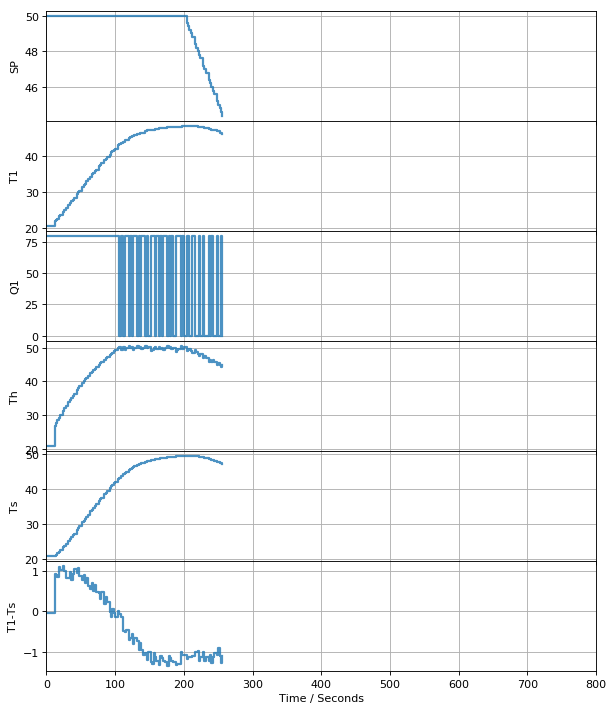

In [ ]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

## Experiment 2. Closed-Loop State Estimation and Relay Control

In the second experiment, use a closed loop estimator and relay control to cause the heater to track a desired temperature setpoint. 

Before performing the experiment, you will need to determine suitable values for the observer gain $L$.  $L$ is a matrix consisting of two rows and one column.  You need to choose the values in $L$ such that $A-LC$ is stable and has acceptable time constants. For this experiment, try

\begin{align*}
L & = \begin{bmatrix} 0.6 \\ 0.3 \end{bmatrix}
\end{align*}

**a.**) Before starting the experiment, compute the eigenvalues and corresponding time constants of $A$ and of $A-LC$. 

**b.**) Then repeat the same tasks for Experiment 1, but this time use a closed-loop estimator. In your answers, be sure to describe how the results of this experiment differ from the first, and explain why.

**c.**) Then repeat the experiment with gains twice as large.

#### Review of Closed Loop Estimation

Examining the results, we see the predicted heater temperature appears to track the desired setpoint, but the sensor temperature is off the mark. This could be due several factors, most likely model error.

Process
\begin{align*}
\frac{dx}{dt} & = A x + B u \\
y & = C x + D u
\end{align*}

Model
\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u \\
\hat{y} & = C \hat{x} + D u
\end{align*}

If the measured and estimated outputs are different, then $y - \hat{y} \neq 0$. Taking the difference we find

\begin{align*}
y - \hat{y} & = C x + Du - C\hat{x} - Du \\
& = C(x - \hat{x})
\end{align*}

The difference $y - \hat{y}$ can be observed.  But what we want is to make $x - \hat{x}$ small. Is there way to use knowledge of $y - \hat{y}$ to reduce $x - \hat{x}$?

The technique is to introduce feedback $L(y-\hat{y})$ to the model.  

\begin{align*}
\frac{d\hat{x}}{dt} & = A \hat{x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{x} + D u
\end{align*}

Subtracting the new model equations from the process model, we get an expression for the dynamics of the model error $e = x - \hat{x]$

\begin{align*}
\frac{de}{dt} & = \frac{dx}{dt} - \frac{d\hat{x}}{dt} \\
\\
& = (Ax + Bu) - (A\hat{x} + Bu + L(Cx - C\hat{x})) \\
\\
& = (A - LC)(x -\hat{x}) \\
\\
\frac{de}{dt} & = (A - LC) e
\end{align*}

The choice of $L$ determines observer performance.

#### Choosing $L$

In [ ]:
import numpy as np

P =  0.04             # power input when the system is turned
Ua = 0.068            # heat transfer coefficient from heater to environment
CpH = 6.50            # heat capacity of the heater (J/deg C)
CpS = 1.25            # heat capacity of the sensor (J/deg C)
Uc = 0.036            # heat transfer coefficient from heater to sensor
Tamb = 21             # ambient room temperature

# state space model
A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
C = [[0, 1]]   # single row
L = [[0.6], [0.3]]

evals, evecs = np.linalg.eig(A)
print('Time Constants of A are:', -1/evals, 'seconds')

evals, evecs = np.linalg.eig(A - np.dot(L,C))
print('Time Constants of A are:', -1/evals, 'seconds')

In [ ]:
import numpy as np
import control 

def tclab():
    # parameter estimates
    P =  0.04             # power input when the system is turned
    Ua = 0.068            # heat transfer coefficient from heater to environment
    CpH = 6.50            # heat capacity of the heater (J/deg C)
    CpS = 1.25            # heat capacity of the sensor (J/deg C)
    Uc = 0.036            # heat transfer coefficient from heater to sensor
    Tamb = 21             # ambient room temperature

    # state space model
    A = [[-(Ua + Uc)/CpH, Uc/CpH], [Uc/CpS, -Uc/CpS]]
    B = [[P/CpH], [0]] # single column
    C = [[0, 1]]   # single row
    D = [[0]]

    # initialize variables that will be updated in time
    t = 0
    x = np.array([0, 0])
    
    # observer gain ... put your values here!
    L = [[????], [????]]
    
    while True:
        # yield the heater temperature to the calling program
        Th = x[0] + Tamb
        Ts = x[1] + Tamb
        tnext, Q, T1 = yield Th, Ts
        dt = tnext - t
        x = x + dt*np.dot(A, x) + dt*np.dot(B, [Q]) + dt*np.dot(L, [T1-Ts])
        t = tnext

In [ ]:
from tclab import setup, clock, Historian, Plotter
TCLab = setup(connected=False, speedup=20)

tf = 800        # run time

# create a controller instance
controller = relay(0, 80)
controller.send(None)

# create an model estimator
estimator = tclab()
estimator.send(None)

# execute the event loop
tf = 800
with TCLab() as lab:
    h = Historian([('SP', lambda: Tsp(t)), ('T1', lambda: lab.T1), ('Q1', lab.Q1),
                   ('Th', lambda: Th), ('Ts', lambda: Ts), ('T1-Ts', lambda: T1-Ts)])
    p = Plotter(h, tf)
    U1 = 0
    for t in clock(tf, 2):                    # allow time for more calculations
        T1 = lab.T1                           # measure the sensor temperature
        Th, Ts = estimator.send([t, U1, T1])  # estimate the heater temperature
        SP = Tsp(t)                           # get setpoint
        U1 = controller.send([SP, Th])        # compute control action
        lab.U1 = U1                           # set manipulated variable  
        p.update(t)                           # log data

## Experiment 3. Closed-Loop State Estimation and Relay Control

Then repeat the experiment with gains twice as large. Report the time constants for the observer. Did you see a substantive change in controller performance.

<!--NAVIGATION-->
< [Coding Controllers with Python Generators](B.11-Coding-Controllers-with-Python-Generators.ipynb) | [Contents](index.ipynb) |

<a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/B.12-Open-and-Closed-Loop-Estimation.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
